In [722]:
from imutils.contours import sort_contours
import numpy as np
import pytesseract
import argparse
import imutils
import sys
import cv2
import json
import jsonpickle
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

In [723]:
#!pip install imutils
#!pip install jsonpickle

In [724]:
image = cv2.imread("../data/passport_data/passport_1.png")
image = cv2.resize(image, (1000, 450))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(H, W) = gray.shape
H,W

(450, 1000)

In [725]:
def show_image(label,image):
    # Using cv2.imshow() method
    # Displaying the image
#     cv2.imshow(label, image)

#     # waits for user to press any key
#     # (this is necessary to avoid Python kernel form crashing)
#     cv2.waitKey(0)

#     # closing all open windows
#     cv2.destroyAllWindows()
    # call imshow() using plt object
    plt.imshow(image)

    # display that image
    plt.show()

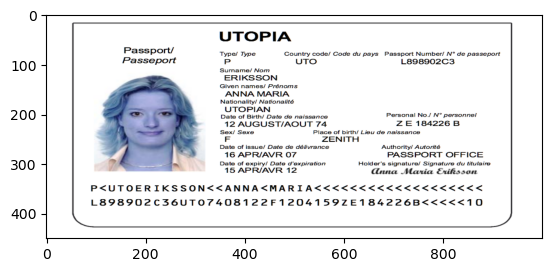

In [726]:
show_image("image",image)

In [727]:

# initialize a rectangular and square structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 7))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
# smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light
# background
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
#show_image("Blackhat", blackhat)
#cv2.imshow("Blackhat", blackhat)

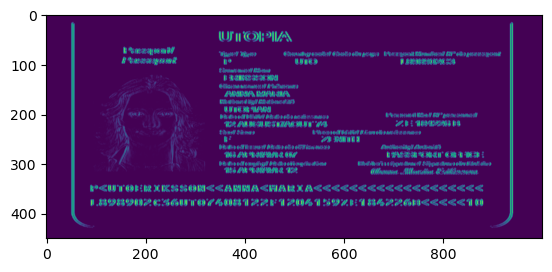

In [728]:
# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
show_image("Gradient", grad)
#cv2.imshow("Gradient", grad)

In [729]:
# apply a closing operation using the rectangular kernel to close
# gaps in between letters -- then apply Otsu's thresholding method
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255,
                       cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

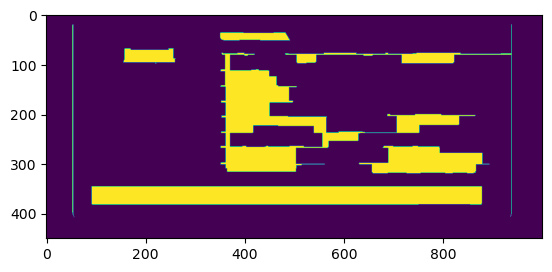

In [730]:
# perform another closing operation, this time using the square
# kernel to close gaps between lines of the MRZ, then perform a
# series of erosions to break apart connected components
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
thresh = cv2.erode(thresh, None, iterations=2)
show_image("Square Close", thresh)
#cv2.imshow("Square Close", thresh)

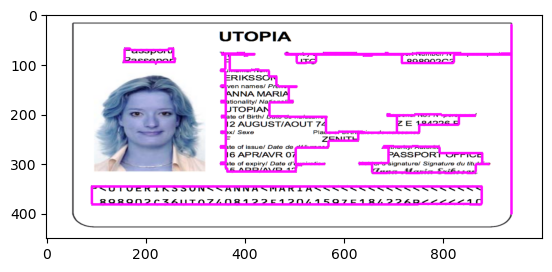

In [731]:
## DETERMINE CONTOURS AND FILTER THEM
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
 
#make a copy of the resized image since we are going to draw contours on the resized image
resizedImageCopy=np.copy(image)
 
# draw all contours with setting the parameter to -1
# but if you use this function, you should comment the for loop below
#cv2.drawContours(resizedImageCopy,contours,-1,(0,0,255),2)
#filter contours 
for i, c in enumerate(contours):
    areaContour=cv2.contourArea(c)
    if areaContour<2000 or 100000<areaContour:
        continue
    cv2.drawContours(resizedImageCopy,contours,i,(255,10,255),4)
     
# # display the original image with contours
# cv2.imshow('Image', resizedImageCopy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.imwrite("resizedPartsContours.png", resizedImageCopy, [cv2.IMWRITE_PNG_COMPRESSION, 0]) 
show_image("resizedPartsContours.png",resizedImageCopy)


In [732]:
# cnts = imutils.grab_contours(contours)
# cnts = sort_contours(contours, method="bottom-to-top")[0]
# # initialize the bounding box associated with the MRZ
mrzBox = None

In [733]:
# # find contours in the thresholded image and sort them from bottom
# # to top (since the MRZ will always be at the bottom of the passport)
# cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
#                         cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
# cnts = sort_contours(cnts, method="bottom-to-top")[0]
# # initialize the bounding box associated with the MRZ
# mrzBox = None

In [734]:
# cnts

In [735]:
W,H

(1000, 450)

In [736]:
# loop over the contours
for i,c in enumerate(contours):
    # compute the bounding box of the contour and then derive the
    # how much of the image the bounding box occupies in terms of
    # both width and height
    (x, y, w, h) = cv2.boundingRect(c)
    percentWidth = w / float(W)
    percentHeight = h / float(H)
    print("bbox=",(x, y, w, h))
    print("contour=",c)
    print("per width = ",percentWidth)
    print("per height = ",percentHeight)
    # if the bounding box occupies > 80% width and > 4% height of the
    # image, then assume we have found the MRZ
    if percentWidth > 0.1 and percentHeight > 0.003:
        mrzBox = (x, y, w, h)
        break


bbox= (56, 407, 1, 1)
contour= [[[ 56 407]]]
per width =  0.001
per height =  0.0022222222222222222
bbox= (936, 406, 1, 1)
contour= [[[936 406]]]
per width =  0.001
per height =  0.0022222222222222222
bbox= (937, 403, 1, 2)
contour= [[[937 403]]

 [[937 404]]]
per width =  0.001
per height =  0.0044444444444444444
bbox= (92, 346, 787, 37)
contour= [[[ 92 346]]

 [[ 92 381]]

 [[ 93 382]]

 [[750 382]]

 [[751 381]]

 [[854 381]]

 [[855 382]]

 [[877 382]]

 [[877 381]]

 [[878 380]]

 [[878 346]]]
per width =  0.787
per height =  0.08222222222222222


In [737]:
mrzBox

(92, 346, 787, 37)

In [738]:
# if the MRZ was not found, exit the script
if mrzBox is None:
    print("[INFO] MRZ could not be found")
    sys.exit(0)
# pad the bounding box since we applied erosions and now need to
# re-grow it
(x, y, w, h) = mrzBox
pX = int((x + w) * 0.03)
pY = int((y + h) * 0.03)
(x, y) = (x - pX, y - pY)
(w, h) = (w + (pX * 2), h + (pY * 2))
# extract the padded MRZ from the image
mrz = image[y:y + h, x:x + w]

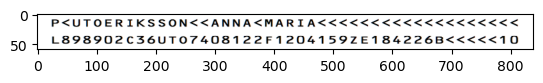

In [739]:
show_image("mrz",mrz)

In [740]:
mrzText = pytesseract.image_to_string(mrz)

In [741]:
mrzlist=mrzText.split('\n')[:-1]
mrzlist

['P<UTOERIKSSON<<ANNA<MARIA<<<<<<<<<<<<<<<<<<<',
 'L898902C36UT07408122F1204159ZE184226B<<<<<10']

In [742]:
mrzlist

['P<UTOERIKSSON<<ANNA<MARIA<<<<<<<<<<<<<<<<<<<',
 'L898902C36UT07408122F1204159ZE184226B<<<<<10']

In [743]:

def retreive_data(mrz_row_list):
#     print(mrz_row_list)
    detail_dict = {}
    line1_words = mrz_row_list[0].split("<")
    line2_words = mrz_row_list[1].split("<")
    detail_dict["Name"] = " ".join(line1_words[2:]) + " "+ line1_words[1][3:]
    detail_dict["country_code"] = line1_words[1][:3]
    detail_dict["pp_no"] = line2_words[0][:9]
    detail_dict["nationality"] = line2_words[0][10:13]
    detail_dict["data_of_birth"] = datetime.strptime(line2_words[0][13:19], "%y%m%d").strftime("%d-%m-%y")
    #detail_dict["data_of_birth"] = line2_words[0][13:19]
    detail_dict["gender"] = line2_words[0][20:21]
    detail_dict["expiry_date"] = datetime.strptime(line2_words[0][21:27], "%d%m%y").strftime("%d-%m-%y")
    #detail_dict["expiry_date"] = line2_words[0][21:27]
    return detail_dict
    

In [744]:
data = retreive_data(mrzlist)
# data

In [745]:
df = pd.DataFrame(data.items(),columns = ["Passport Key","Value"])

In [746]:
df

,Passport Key,Value
0,Name,ANNA MARIA ERIKSSON
1,country_code,UTO
2,pp_no,L898902C3
3,nationality,UT0
4,data_of_birth,12-08-74
5,gender,F
6,expiry_date,12-04-15


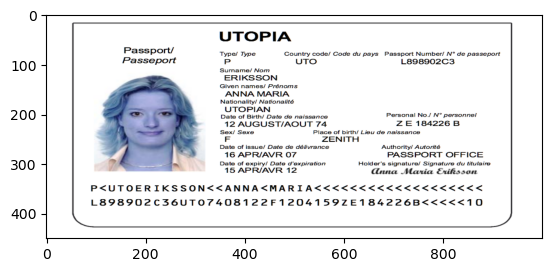

In [747]:
show_image("image",image)